<a href="https://colab.research.google.com/github/Cinex10/Architect-hub/blob/main/BITCOIN_PRICES_PREDICTION_USING_TRANSFORMER_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=a757a299b79d2508020e592e2346952a8d9a8e91e6159d715359d216e0c71cfd
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
import pandas_ta as ta

print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.12.0


<ipython-input-2-26bfdee539cd>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')


Running on TPU  ['10.7.39.82:8470']


In [4]:
# If TPU found, we set up the distribution strategy
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [11]:
BTC_Ticker = yf.Ticker("BTC-USD")
df = BTC_Ticker.history(period="max")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3232 entries, 2014-09-17 00:00:00+00:00 to 2023-07-24 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3232 non-null   float64
 1   High          3232 non-null   float64
 2   Low           3232 non-null   float64
 3   Close         3232 non-null   float64
 4   Volume        3232 non-null   int64  
 5   Dividends     3232 non-null   float64
 6   Stock Splits  3232 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 202.0 KB


## Preprocessing methods

In [6]:
def calculate_change(df,column='Close',name='Close_diff'):
  df[name] = df[column].shift(-1) - df[column]
  return df

In [7]:
def calcualte_ti(df,column='Close'):
  if(column in df.columns):
    df[f'{column}_SMA']=ta.sma(df[column],length=15)
    # df[f'{column}_RSI']=ta.rsi(df[column], length=15)
    # df[f'{column}_EMAF']=ta.ema(df[column], length=20)
    # df[f'{column}_EMAM']=ta.ema(df[column], length=100)
    # df[f'{column}_EMAS']=ta.ema(df[column], length=150)
    # macd = ta.macd(df[column])
    # df[f'{column}_MACD'] = macd['MACD_12_26_9']
    # df[f'{column}_MACD_Signal'] = macd['MACDs_12_26_9']
    # df[f'{column}_MACD_Histogram'] = macd['MACDh_12_26_9']
  return df

In [8]:
def calculate_percentage_change(df,columns):
  for column in columns:
    if column in df.columns:
      # name = f'{column}_pct_change'
      df[column] = df[column].pct_change()
  return df

In [9]:
def drop_columns(df,columns=['Open','High','Low','Volume' ,'Dividends','Stock Splits']):
  df.drop(columns=columns,axis=0,inplace=True)
  return df

In [10]:
# last_entry = df[-1:]

In [11]:
def dropna(df):
  df.dropna(inplace=True)
  return df

In [12]:
def minmax_scaling(df,columns):
  scaler = MinMaxScaler(feature_range=(0,1))
  df[columns] = scaler.fit_transform(df[columns])
  return df

## Preprocessing pipeline

In [31]:
BTC_Ticker = yf.Ticker("BTC-USD")
df = BTC_Ticker.history(period="max")
df = (df.pipe(calcualte_ti,column='Close')
        # .pipe(calcualte_ti,column='Open')
        # .pipe(calcualte_ti,column='High')
        # .pipe(calcualte_ti,column='Low')
        .pipe(calculate_percentage_change,columns=df.columns)
        .pipe(drop_columns,columns=['Dividends','Stock Splits','Open','Close','Low','High','Volume'])
        .pipe(dropna)
        .pipe(minmax_scaling,columns=df.columns)
        )

In [32]:
df.head()

,Close_SMA
Date,
2014-10-02 00:00:00+00:00,0.211234
2014-10-03 00:00:00+00:00,0.239213
2014-10-04 00:00:00+00:00,0.236241
2014-10-05 00:00:00+00:00,0.195342
2014-10-06 00:00:00+00:00,0.228139


## Split dataset

In [33]:
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]
df_train = df[df.index.values < last_20pct]
df_val = df[(df.index.values >= last_20pct) & (df.index.values < last_10pct)]
df_test = df[(df.index.values >= last_10pct)]

In [34]:
df_train.shape

(2576, 1)

In [35]:
print('Training data shape: {}'.format(df_train.shape))
print('Validation data shape: {}'.format(df_val.shape))
print('Test data shape: {}'.format(df_test.shape))

Training data shape: (2576, 1)
Validation data shape: (322, 1)
Test data shape: (321, 1)


Text(0.5, 0, 'Date')

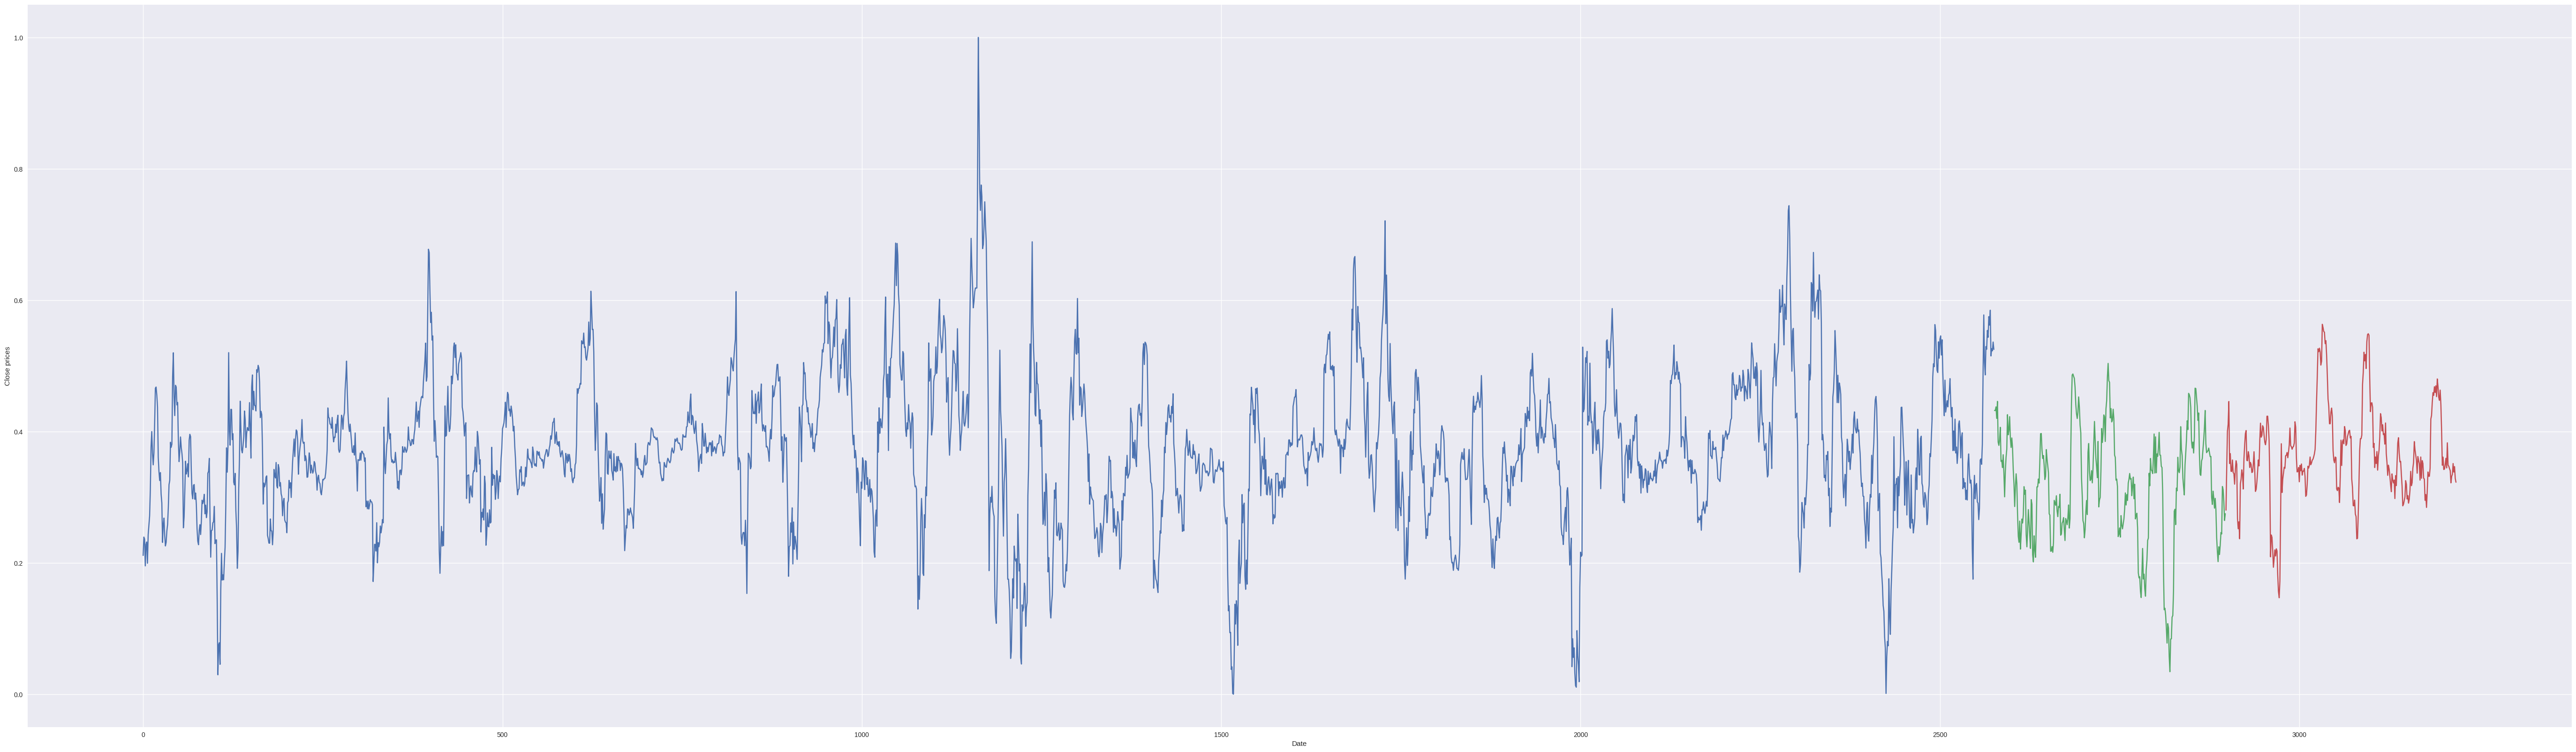

In [36]:
plt.figure(figsize=(70,20))
plt.plot(np.arange(df_train.shape[0]),df_train['Close_SMA'],label='Training data')
plt.plot(np.arange(df_train.shape[0],df_train.shape[0]+df_val.shape[0]),df_val['Close_SMA'],label='Validation data')
plt.plot(np.arange(df_train.shape[0]+df_val.shape[0],df_train.shape[0]+df_val.shape[0]+df_test.shape[0]),df_test['Close_SMA'],label='Test data')

plt.ylabel('Close prices')
plt.xlabel('Date')


## Create sequences

In [37]:
def create_sequences(df,target_columns='Close_SMA',seq_len=128):
  X_seq, y_seq = [], []
  X,y = df.values, df[target_columns].values
  for i in range(seq_len, len(df)):
    X_seq.append(X[i-seq_len:i])
    y_seq.append(y[i])
  X_seq, y_seq = np.array(X_seq), np.array(y_seq)
  return X_seq,y_seq

In [38]:
seq_len = 128
# Training data
X_train, y_train = create_sequences(df_train)

# Validation data
X_val, y_val = create_sequences(df_val)

# Test data
X_test, y_test = create_sequences(df_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (2448, 128, 1) (2448,)
Validation set shape (194, 128, 1) (194,)
Testing set shape (193, 128, 1) (193,)


# Modeling

## Layers

In [39]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

    self.key = Dense(self.d_k,
                     input_shape=input_shape,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='glorot_uniform')

    self.value = Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)

    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
    self.linear = Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

## Build model

In [40]:
X_train.shape[-1]

1

In [41]:
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
n_features = X_train.shape[-1]
n_output = 1

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  # attn_layer4 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, n_features))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  # x = attn_layer4((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(n_output, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


# Training

In [42]:
batch_size = 32

with tpu_strategy.scope():
  model = create_model()
  callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding4.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=35,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding4.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


################################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)


Epoch 1/35
77/77 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.1249 - mape: 81893.0000
Epoch 1: val_loss improved from inf to 0.01118, saving model to Transformer+TimeEmbedding4.hdf5
77/77 [==============================] - 129s 555ms/step - loss: 0.0290 - mae: 0.1249 - mape: 81893.0000 - val_loss: 0.0112 - val_mae: 0.0775 - val_mape: 44.9445
Epoch 2/35
77/77 [==============================] - ETA: 0s - loss: 0.0128 - mae: 0.0854 - mape: 164556.7188
Epoch 2: val_loss did not improve from 0.01118
77/77 [==============================] - 4s 56ms/step - loss: 0.0128 - mae: 0.0854 - mape: 164556.7188 - val_loss: 0.0129 - val_mae: 0.0841 - val_mape: 48.6288
Epoch 3/35
77/77 [==============================] - ETA: 0s - loss: 0.0129 - mae: 0.0851 - mape: 147430.6875
Epoch 3: val_loss improved from 0.01118 to 0.00995, saving model to Transformer+TimeEmbedding4.hdf5
77/77 [==============================] - 7s 94ms/step - loss: 0.0129 - mae: 0.0851 - mape: 147430.6875 - val_

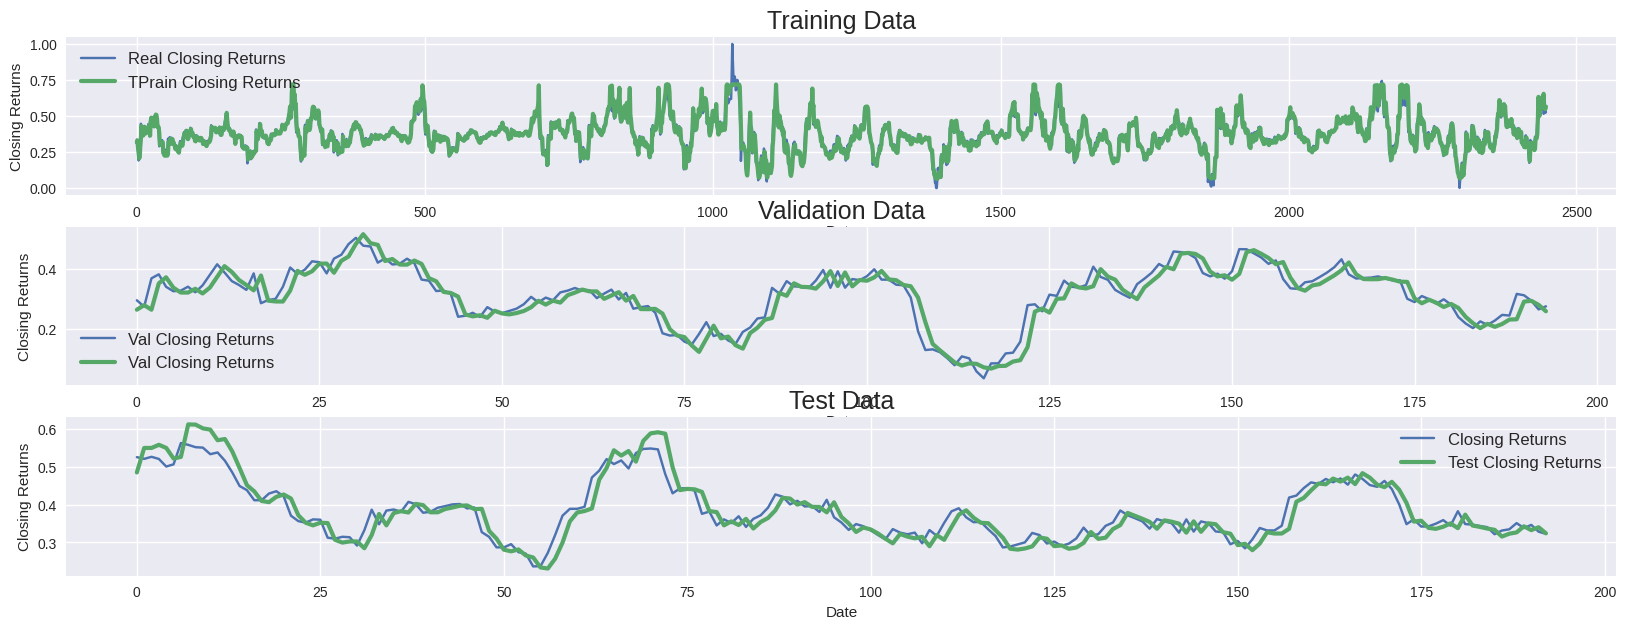

In [43]:
fig = plt.figure(figsize=(20,7))


#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(y_train, label='Real Closing Returns')
ax11.plot(train_pred, linewidth=3, label='TPrain Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(y_val, label='Val Closing Returns')
ax21.plot(val_pred, linewidth=3, label='Val Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(y_test, label='Closing Returns')
ax31.plot(test_pred, linewidth=3, label='Test Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [ ]:
#Print evaluation metrics for all datasets
print('Evaluation metrics')
print(' ')
train_eval = model.evaluate(X_train, y_train, verbose=0)
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
val_eval = model.evaluate(X_val, y_val, verbose=0)
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
test_eval = model.evaluate(X_test, y_test, verbose=0)
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

Evaluation metrics
 
Training Data - Loss: 0.0040, MAE: 0.0422, MAPE: 252343.4844
Validation Data - Loss: 0.0032, MAE: 0.0401, MAPE: 7.1137
Test Data - Loss: 0.0016, MAE: 0.0275, MAPE: 4.5027
